# PROYECTO INDIVIDUAL

## Pablo Campos V. - 108783
### Datos: Mortalidad (Proyecto 5)

### Importación de Spark y definición del SparkContext y el SQLContext

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')
sqlContext = pyspark.SQLContext(sc)

In [92]:
from pyspark.sql import Row
from pyspark.sql.types import *
import pandas as pd

### Comprobamos que el archivo de los datos están en el working directory

In [185]:
! ls

GBD_Classification_23NOV2015.psv  proyecto_indiv.ipynb


### Lectura del archivo como RDD

In [5]:
raw_data = sc.textFile("GBD_Classification_23NOV2015.psv")

### Obtención del header

In [8]:
header = raw_data.first()

In [9]:
print(header)

"control"|"s_state"|"s_mun"|"s_hab"|"st_loc"|"state_die"|"mun_die"|"cause"|"gender"|"year_die"|"month_die"|"day_die"|"year_reg"|"month_reg"|"year_bir"|"month_bir"|"day_bir"|"occup"|"mar_st"|"presum"|"at_work"|"place_die"|"necrop"|"med_assi"|"unit_die"|"cert_byd"|"cert_nod"|"nat"|"hcare"|"preg_con"|"preg_rel"|"hour_die"|"min_die"|"age_corr"|"regis"|"viol"|"state_reg"|"mun_reg"|"loc_reg"|"s_loc"|"loc_die"|"t_loc_die"|"day_reg"|"weight"|"year_cert"|"month_cert"|"day_cert"|"com_preg"|"cond_cert"|"cond_act"|"stmunres"|"GBD_cause"|"GBD_subcause"|"WR"|"dead"|"imputed"|"GBD_cat"|"ed_re"|"marst_re"|"placedie_re"|"YLLg"|"YLLg2"|"cohort"|"extralife"|"YLLe"|"YLLe2"|"YLLe3"|"YLLg3"


In [77]:
Colnames = Row('control','s_state','s_mun','s_hab', 'st_loc', 'state_die', 'mun_die','cause', 'gender', 'year_die', 'month_die',
              'day_die','year_reg','month_reg','year_bir','month_bir','day_bir','occup','mar_st','presum','at_work','place_die',
              'necreop','med_assi','unit_die','cert_byd','cert_not','nat','hcare','preg_con','preg_rel','hour_die','min_die',
              'age_corr','regis','viol','state_reg','mun_reg','loc_reg','s_loc','loc_die','t_loc_die','day_reg','weight','year_cert',
              'month_cert','day_cert','com_preg','cond_cert','cond_act','stmunres','GBD_cause','GBD_subcause','WR','dead','imputed',
              'GBD_cat','ed_re','marst_re','placedie_re','YLLg','YLLg2','cohort','extralife','YLLe','YLLe2','YLLe3','YLLg3')

def getSchema(linea):
            return Colnames(*linea)

### Creación del DataFrame de Spark:
### Se elimina el header, sustituimos "NA" y comillas por espacios, separamos  Pipe y obtenemos el esquema

In [103]:
df_data = raw_data.filter(lambda line: line != header)\
                    .map(lambda line: line.replace('"', ''))\
                    .map(lambda line: line.replace('NA', ''))\
                    .map(lambda x: x.split('|')) \
                    .map(lambda x: getSchema(x))\
                    .toDF()

### Se registra este DataFrame para poder realizar queries via sqlContext.sql()

In [ ]:
df_data.registerTempTable('df')

In [131]:
sqlContext.sql("show tables").show()

+---------+-----------+
|tableName|isTemporary|
+---------+-----------+
|       df|       true|
+---------+-----------+



### Número de registros en el DataFrame

In [106]:
sqlContext.sql("select count(*) from df").show()

+-------+
|    _c0|
+-------+
|8157598|
+-------+



### Visualizamos el esquema del DataFrame

In [108]:
df_data.printSchema()

root
 |-- control: string (nullable = true)
 |-- s_state: string (nullable = true)
 |-- s_mun: string (nullable = true)
 |-- s_hab: string (nullable = true)
 |-- st_loc: string (nullable = true)
 |-- state_die: string (nullable = true)
 |-- mun_die: string (nullable = true)
 |-- cause: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- year_die: string (nullable = true)
 |-- month_die: string (nullable = true)
 |-- day_die: string (nullable = true)
 |-- year_reg: string (nullable = true)
 |-- month_reg: string (nullable = true)
 |-- year_bir: string (nullable = true)
 |-- month_bir: string (nullable = true)
 |-- day_bir: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- mar_st: string (nullable = true)
 |-- presum: string (nullable = true)
 |-- at_work: string (nullable = true)
 |-- place_die: string (nullable = true)
 |-- necreop: string (nullable = true)
 |-- med_assi: string (nullable = true)
 |-- unit_die: string (nullable = true)
 |-- cert_byd: st

### Elegimos para trabajar las columnas: control, s_state, cause, gender, year_die

In [123]:
sqlContext.sql("select control, s_state, cause, gender, year_die from df limit 10").show()

+-----------+-------+-----+------+--------+
|    control|s_state|cause|gender|year_die|
+-----------+-------+-----+------+--------+
|15010010001|      1| C509|     2|    1998|
|15010010001|      1| V099|     1|    1998|
|15010010001|      1| F102|     1|    1998|
|15010010001|      1| C249|     2|    1998|
|15010010001|      1| C716|     2|    1998|
|15010010001|      1| I420|     2|    1998|
|15010010001|      1| P021|     1|    1998|
|15010010001|      1| K254|     2|    1998|
|15010010001|      1| I219|     2|    1998|
|15010010001|      1| E149|     2|    1998|
+-----------+-------+-----+------+--------+



### Definimos una funcion para que Spark tome los campos vacios como missings

In [120]:
from pyspark.sql.functions import col, when

def reemplaza(x):
    return when(col(x) != "", col(x)).otherwise(None)

In [125]:
df_data = df_data.withColumn("s_state", reemplaza("s_state"))
df_data = df_data.withColumn("cause", reemplaza("cause"))
df_data = df_data.withColumn("gender", reemplaza("gender"))
df_data = df_data.withColumn("year_die", reemplaza("year_die"))

### Creamos un nuevo DataFrame con el subconjunto de columnas a utilizar

In [146]:
df_sub = df_data.select(df_data['control'], df_data['s_state'], df_data['cause'], df_data['gender'],df_data['year_die'])

### Vemos el esquema del nuevo DataFrame

In [147]:
df_sub.printSchema()

root
 |-- control: string (nullable = true)
 |-- s_state: string (nullable = true)
 |-- cause: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- year_die: string (nullable = true)



### Visualizamos unos cuantos renglones

In [148]:
df_sub.show(5)

+-----------+-------+-----+------+--------+
|    control|s_state|cause|gender|year_die|
+-----------+-------+-----+------+--------+
|15010010001|      1| C509|     2|    1998|
|15010010001|      1| V099|     1|    1998|
|15010010001|      1| F102|     1|    1998|
|15010010001|      1| C249|     2|    1998|
|15010010001|      1| C716|     2|    1998|
+-----------+-------+-----+------+--------+
only showing top 5 rows



### Registramos este nuevo DataFrame para los queries subsecuentes

In [150]:
df_sub.registerTempTable('df_sub')

### Realizamos el cast de las columnas que necesitamos en formato numérico

In [151]:
df_sub_1 = sqlContext.sql("select control, cast(s_state as FLOAT) as s_state, cause, cast(gender as INT) as gender, cast(year_die as FLOAT) as year_die from df_sub")

In [152]:
df_sub_1.registerTempTable('df_sub_1')

### Visualizamos el DataFrame después de realizar el cast

In [153]:
df_sub_1.show()

+-----------+-------+-----+------+--------+
|    control|s_state|cause|gender|year_die|
+-----------+-------+-----+------+--------+
|15010010001|    1.0| C509|     2|  1998.0|
|15010010001|    1.0| V099|     1|  1998.0|
|15010010001|    1.0| F102|     1|  1998.0|
|15010010001|    1.0| C249|     2|  1998.0|
|15010010001|    1.0| C716|     2|  1998.0|
|15010010001|    1.0| I420|     2|  1998.0|
|15010010001|    1.0| P021|     1|  1998.0|
|15010010001|    1.0| K254|     2|  1998.0|
|15010010001|    1.0| I219|     2|  1998.0|
|15010010001|    1.0| E149|     2|  1998.0|
|15010010001|    1.0| G809|     1|  1998.0|
|15010010001|    1.0| E785|     2|  1998.0|
|15010010001|    1.0| I259|     1|  1998.0|
|15010010001|    1.0| E128|     2|  1998.0|
|15010010001|    1.0| I269|     2|  1998.0|
|15010010001|    1.0| E149|     2|  1998.0|
|15010010001|    1.0| K275|     1|  1998.0|
|15010010001|   14.0| X599|     2|  1998.0|
|15010010001|    1.0| X599|     1|  1998.0|
|15010010001|    1.0| Q249|     

### Vemos el nuevo esquema después del cast

In [155]:
df_sub_1.printSchema()

root
 |-- control: string (nullable = true)
 |-- s_state: float (nullable = true)
 |-- cause: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- year_die: float (nullable = true)



### Realizamos un query para obtener las causas de muerte mas frecuentes

In [161]:
by_cause = sqlContext.sql("select cause, count(cause) from df_sub_1 group by cause")
by_cause.registerTempTable('by_cause')
by_cause_sort = sqlContext.sql("select cause, _c1 from by_cause order by _c1 desc")

+-----+-----+
|cause|  _c1|
+-----+-----+
| C900|11794|
| B019|  895|
| K768|  840|
| K650|10383|
| Q780|  395|
| W739|  545|
| B190|  462|
| Q898|  574|
| A010| 1161|
| R220|    6|
| D134|   91|
| L703|    1|
| F411|   26|
| V235|   38|
| W126|  126|
| N26X|  221|
| C694|   50|
| Y241|   16|
| X017|   30|
| Q447|  193|
+-----+-----+
only showing top 20 rows



### Llevamos el DataFrame ordenado a un Pandas DataFrame para visualizar los resultados

In [175]:
by_cause_sort.registerTempTable('by_cause_sort')
by_cause_sort_pd = by_cause_sort.toPandas()

In [179]:
by_cause_sort_pd.head()

,cause,_c1
0,I219,752901
1,E112,222223
2,K746,193455
3,K703,170979
4,E119,168267


In [180]:
by_cause_sort_pd.tail()

,cause,_c1
6715,X016,1
6716,L658,1
6717,B469,1
6718,Y402,1
6719,B351,1


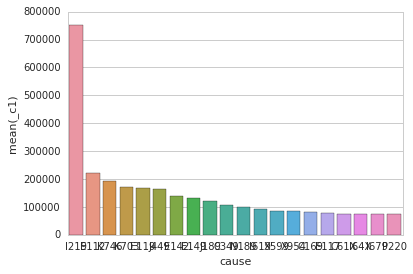

In [183]:
sns.set_style("whitegrid")
sns.barplot(x="cause", y="_c1", data=by_cause_sort_pd[:20])

### Realizamos un query para obtener el número de muertes por año y llevamos los resultados a un Pandas DataFrame para visualizar

In [165]:
by_year = sqlContext.sql("select year_die, count(year_die) from df_sub_1 group by year_die")
by_year.registerTempTable('by_year')
by_year_pd = by_year.toPandas()

In [166]:
by_year_pd.head()

,year_die,_c1
0,2007,513790
1,2006,493693
2,2005,495734
3,2004,472639
4,2003,471711


In [168]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

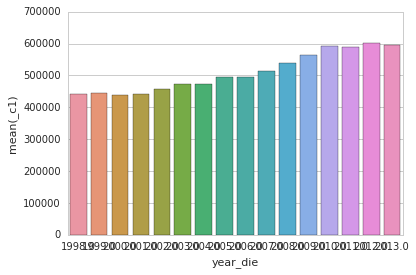

In [174]:
sns.set_style("whitegrid")
sns.barplot(x="year_die", y="_c1", data=by_year_pd)